# 040 GDAL: mosaicing and masking

### Purpose


In this section, we'll look at combining both raster and vector data to provide a masked dataset ready to use. We will produce a combined dataset of leaf area index (LAI) over the UK derived from the MODIS sensor that we have examined before.

At the end of this session, you should be able to use one or more of these methods to obtain a numpy array with a MODIS datatset for a particular place and time.


### Prerequisites

You will need some understanding of the following:


* [001 Using Notebooks](001_Notebook_use.ipynb)
* [010 Variables, comments and print()](010_Python_Introduction.ipynb)
* [011 Data types](011_Python_data_types.ipynb) 
* [012 String formatting](012_Python_strings.ipynb)
* [013_Python_string_methods](013_Python_string_methods.ipynb)
* [020_Python_files](020_Python_files.ipynb)
* [021 Streams](021_Streams.ipynb)
* [022 Read write files](022_Read_write_files.ipynb)
* [023 Plotting](023_Plotting.ipynb)
* [024 Image display](024_Image_display.ipynb)
* [030 NASA MODIS Earthdata](030_NASA_MODIS_Earthdata.ipynb)
* [031 Numpy](031_Numpy.ipynb)
* [032 More numpy](032_More_numpy.ipynb)

You will need to remember:

* [the SDS in MODIS datasets](030_NASA_MODIS_Earthdata.ipynb)
* how to do [`numpy` slicing](032_More_numpy.ipynb#slicing) and numpy functions to get [array statistics](031_Numpy.ipynb#Summary-statistics)

### Test

You should run a [NASA account test](004_Accounts.ipynb) if you have not already done so.

## MODIS dataset access

You should by now be able to access MODIS data, through the various routines in [`modisUtils.py`](geog0111/modisUtils.py) we have used in [024 Image display](024_Image_display.ipynb#MODIS)
 and [030 NASA MODIS Earthdata](030_NASA_MODIS_Earthdata.ipynb).
 
 If we want more complex access, we can use `getModisFiles` to return a dictionary of multiple days, tiles, and SDS. We can use this information as the basis for creating tiles datasets in `gdal`.

In [1]:
from geog0111.modisUtils import getModisFiles

kwargs = {
    'product'    : 'MCD15A3H',
    'tile'       : ['h17v03','h18v03'],
    'year'       : 2019,
    'doys'       : [41],
    'sds'        : ['Lai_500m']
}

data_MCD15A3H = getModisFiles(verbose=False,timeout=1000,**kwargs)
data_MCD15A3H

{'Lai_500m': {41: {'h17v03': 'HDF4_EOS:EOS_GRID:"/home/ucfalew/.modis_cache/e4ftl01.cr.usgs.gov/MOTA/MCD15A3H.006/2019.02.10/MCD15A3H.A2019041.h17v03.006.2019050221756.hdf":MOD_Grid_MCD15A3H:Lai_500m',
   'h18v03': 'HDF4_EOS:EOS_GRID:"/home/ucfalew/.modis_cache/e4ftl01.cr.usgs.gov/MOTA/MCD15A3H.006/2019.02.10/MCD15A3H.A2019041.h18v03.006.2019050221757.hdf":MOD_Grid_MCD15A3H:Lai_500m'}}}

An example of the full dataset name is:

In [2]:
print(data_MCD15A3H['Lai_500m'][41]['h17v03'])

HDF4_EOS:EOS_GRID:"/Users/plewis/.modis_cache/e4ftl01.cr.usgs.gov/MOTA/MCD15A3H.006/2019.02.10/MCD15A3H.A2019041.h17v03.006.2019050221756.hdf":MOD_Grid_MCD15A3H:Lai_500m


Armed with the SDS description, we can read a dataset from the MODIS file using `g.ReadAsArray()` after we have opened it. It returns a numpy array. We introduce `np.unique` that returns the unique values in a numpy array:

In [3]:
import gdal
import numpy as np

this_sds = data_MCD15A3H['Lai_500m'][41]['h17v03']
# open the SDS of dataset 0
g = gdal.Open(this_sds)
data = g.ReadAsArray()
del g
print(type(data))
print('max:',data.max())
print('max:',data.min())
# get unique values, for interest
print('unique values:',np.unique(data))

<class 'numpy.ndarray'>
max: 255
max: 0
unique values: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70 250
 253 254 255]


#### Exercise 1

Recall that the MODIS LAI data need a scaling factor of 0.1 applied, and that values of greater than 100 are invalid.

For the dataset described by:

    kwargs = {
        'product'    : 'MCD15A3H',
        'tile'       : ['h17v03','h18v03'],
        'year'       : 2019,
        'doys'       : [41],
        'sds'        : ['Lai_500m']
    }

* Use `gdal` to read the data into a `numpy` array called lai
* print the shape of the array `lai`
* Find the maximum valid LAI value in the dataset
* find at least one pixel (row, column) which has that maximum value.

You will need to recall how to filter and [mask `numpy` arrays](032_More_numpy.ipynb#argmin,-argmax-and-masking) and use [`np.where`](032_More_numpy.ipynb#where).

## Tile stitching with `gdal.BuildVRT`

Each MODIS tile has (SDS) datasets that are typically 1200x1200 pixels (1 km resolution) or 2400x2400 pixels (500 m resolution). Whilst we have to consider the MODIS tiles when downloading a dataset, after that point, we will probably want to work with data over some area that may only be a portion of a tile, or that may involve multiple tiles.

One approach to this is to read the individual tile data as above, the sub-set or stitch together multiple tiles. This is perfectly possible using `numpy` (see [`np.vstack`](https://numpy.org/doc/stable/reference/generated/numpy.vstack.html) and [`np.hstack`](https://numpy.org/doc/stable/reference/generated/numpy.hstack.html) to follow that up), but not generally very convenient. 

Another factor is that, whilst the datasets are on regular grids, each location in the grid covers a unique geographical area. Once we load the data into a `numpy` array, we are no longer using the coordinate information available in the original geospatial dataset.

A final factor can be that it might be memory-inefficient to process data by reading it all into a large array.

Instead then, we can use `gdal` to stitch together geospatial data. A convenient way of doing this is to form a new `gdal` [virtual file](https://www.gdal.org/gdal_vrttut.html), using gdal.BuildVRT (check the documentation). 

This function takes two inputs: the output filename (in the variable `ofile`) and a set of GDAL format filenames. 

Let;'s first generate the dataset of filenames:

In [6]:
import gdal
from geog0111.modisUtils import getModisFiles

kwargs = {
    'product'    : 'MCD15A3H',
    'tile'       : ['h17v03','h18v03','h17v04','h18v04'],
    'year'       : 2019,
    'doys'       : [41],
    'sds'        : ['Lai_500m']
}

data_MCD15A3H = getModisFiles(verbose=False,timeout=5000,**kwargs)
data_MCD15A3H

{'Lai_500m': {41: {'h17v03': 'HDF4_EOS:EOS_GRID:"/Users/plewis/.modis_cache/e4ftl01.cr.usgs.gov/MOTA/MCD15A3H.006/2019.02.10/MCD15A3H.A2019041.h17v03.006.2019050221756.hdf":MOD_Grid_MCD15A3H:Lai_500m',
   'h18v03': 'HDF4_EOS:EOS_GRID:"/Users/plewis/.modis_cache/e4ftl01.cr.usgs.gov/MOTA/MCD15A3H.006/2019.02.10/MCD15A3H.A2019041.h18v03.006.2019050221757.hdf":MOD_Grid_MCD15A3H:Lai_500m',
   'h17v04': 'HDF4_EOS:EOS_GRID:"/Users/plewis/.modis_cache/e4ftl01.cr.usgs.gov/MOTA/MCD15A3H.006/2019.02.10/MCD15A3H.A2019041.h17v04.006.2019050222228.hdf":MOD_Grid_MCD15A3H:Lai_500m',
   'h18v04': 'HDF4_EOS:EOS_GRID:"/Users/plewis/.modis_cache/e4ftl01.cr.usgs.gov/MOTA/MCD15A3H.006/2019.02.10/MCD15A3H.A2019041.h18v04.006.2019050220136.hdf":MOD_Grid_MCD15A3H:Lai_500m'}}}

This returns a hierarchy of dictionaries.

The top level is the sds (`Lai_500m` here). Then `doy` (`41` here). 

At the bottom level we have:

In [7]:
doy_v = data_MCD15A3H['Lai_500m'][41]
doy_v

{'h17v03': 'HDF4_EOS:EOS_GRID:"/Users/plewis/.modis_cache/e4ftl01.cr.usgs.gov/MOTA/MCD15A3H.006/2019.02.10/MCD15A3H.A2019041.h17v03.006.2019050221756.hdf":MOD_Grid_MCD15A3H:Lai_500m',
 'h18v03': 'HDF4_EOS:EOS_GRID:"/Users/plewis/.modis_cache/e4ftl01.cr.usgs.gov/MOTA/MCD15A3H.006/2019.02.10/MCD15A3H.A2019041.h18v03.006.2019050221757.hdf":MOD_Grid_MCD15A3H:Lai_500m',
 'h17v04': 'HDF4_EOS:EOS_GRID:"/Users/plewis/.modis_cache/e4ftl01.cr.usgs.gov/MOTA/MCD15A3H.006/2019.02.10/MCD15A3H.A2019041.h17v04.006.2019050222228.hdf":MOD_Grid_MCD15A3H:Lai_500m',
 'h18v04': 'HDF4_EOS:EOS_GRID:"/Users/plewis/.modis_cache/e4ftl01.cr.usgs.gov/MOTA/MCD15A3H.006/2019.02.10/MCD15A3H.A2019041.h18v04.006.2019050220136.hdf":MOD_Grid_MCD15A3H:Lai_500m'}

which has keys `h17v03`, `h18v03`, `h17v04` and `h18v04`, and values giving the SDS dataset full names.

We can usefully form a compound string of the tiles to use in a filename:

In [8]:
tiles = doy_v.keys()
'Tiles_'+'_'.join(tiles)

'Tiles_h17v03_h18v03_h17v04_h18v04'

Let's loop around now and go over each level of the dictionary to form the filenames:

In [9]:
for sds,sds_v in data_MCD15A3H.items():
    print('sds',sds)
    for doy,doy_v in sds_v.items():
        print('doy',doy)
        # build a VRT 
        tiles = doy_v.keys()
        
        ofile = f"work/stitch_{sds}_{kwargs['year']}_{doy:03d}_{'Tiles_'+'_'.join(tiles)}.vrt"
        print(f'saving to {ofile}')      

sds Lai_500m
doy 41
saving to work/stitch_Lai_500m_2019_041_Tiles_h17v03_h18v03_h17v04_h18v04.vrt


Now let's call the `gdal.BuildVRT()` function information:

In [10]:
for sds,sds_v in data_MCD15A3H.items():
    print('sds',sds)
    for doy,doy_v in sds_v.items():
        print('doy',doy)
        # build a VRT 
        tiles = doy_v.keys()
        
        ofile = f"work/stitch_{sds}_{kwargs['year']}_{doy:03d}_{'Tiles_'+'_'.join(tiles)}.vrt"
        print(f'saving to {ofile}')    
        stitch_vrt = gdal.BuildVRT(ofile, list(doy_v.values()))
        del stitch_vrt

sds Lai_500m
doy 41
saving to work/stitch_Lai_500m_2019_041_Tiles_h17v03_h18v03_h17v04_h18v04.vrt


The `del` command in the loop forces the VRT files to be closed.

We can check what it looks like with e.g. `gdal.Info`.

In [11]:
ofile = 'work/stitch_Lai_500m_2019_041_Tiles_h17v03_h18v03_h17v04_h18v04.vrt'
stitch_vrt = gdal.Open(ofile)
print(gdal.Info(stitch_vrt))

Driver: VRT/Virtual Raster
Files: work/stitch_Lai_500m_2019_041_Tiles_h17v03_h18v03_h17v04_h18v04.vrt
Size is 4800, 4800
Coordinate System is:
PROJCRS["unnamed",
    BASEGEOGCRS["Unknown datum based upon the custom spheroid",
        DATUM["Not specified (based on custom spheroid)",
            ELLIPSOID["Custom spheroid",6371007.181,0,
                LENGTHUNIT["metre",1,
                    ID["EPSG",9001]]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433,
                ID["EPSG",9122]]]],
    CONVERSION["unnamed",
        METHOD["Sinusoidal"],
        PARAMETER["Longitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["False easting",0,
            LENGTHUNIT["Meter",1],
            ID["EPSG",8806]],
        PARAMETER["False northing",0,
            LENGTHUNIT["Meter",1],
            ID["EPSG",8807]]],
    CS[Cartesian,2],
        AXIS["easting",east,
            ORDER[1],

So we see that we now have 4800 columns by 4800 rows dataset, centered around 0 degrees North, 0 degrees W. Let's plot the data.

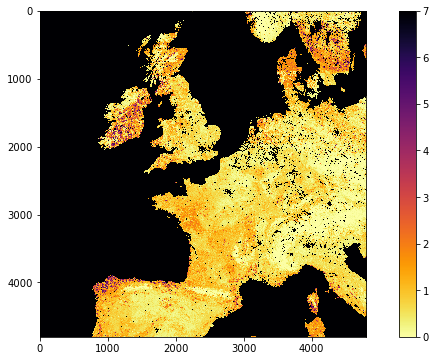

In [12]:
import matplotlib.pyplot as plt

ofile = 'work/stitch_Lai_500m_2019_041_Tiles_h17v03_h18v03_h17v04_h18v04.vrt'
stitch_vrt = gdal.Open(ofile)

fig, axs = plt.subplots(1,1,figsize=(12,6))
im = axs.imshow(stitch_vrt.ReadAsArray()*0.1,vmax=7,\
                cmap=plt.cm.inferno_r,interpolation='nearest')
fig.colorbar(im, ax=axs)


#### Exercise 2

* write a function called `stitchModisDate` that you give the arguments:

    * year
    * doy
    
and keywords/defaults:
    
    * sds='Lai_500m'
    * tile=['h17v03','h18v03']
    * product='MCD15A3H'
    
that then generates a stitched VRT file with the appropriate data, and returns the VRT filename. Make sure to use the `year` and `doy` in the VRT filename, along with the tiles, as in the examples above.

Try to design the code so that you could specify multiple doys.

## Sub-setting 


We have seen in [032 More numpy](032_More_numpy.ipynb) how we can use the idea of slicing to sub-set an array:

    array[start:stop:step]

The dataset we read in the previous section was 4800 x 4800 pixels. If we wanted to generate a sub-set for pixels in the Pyrenees for example, we could inspect the image above, and see that this would be covered by about:

    array[3900:4400,2000:3000]
    
We can use standard [`numpy` slicing](032_More_numpy.ipynb#slicing) to sub-set then:

In [15]:
xx = '1234.vrt'
xx[:-4]

'1234'

shape was (4800, 4800)
shape now (500, 1000)


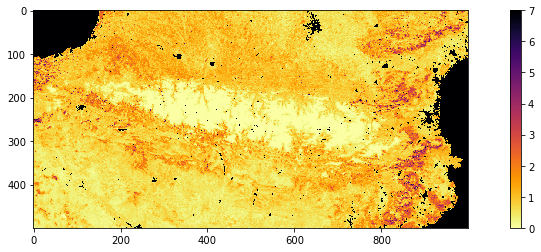

In [16]:
ofile = 'work/stitch_Lai_500m_2019_041_Tiles_h17v03_h18v03_h17v04_h18v04.vrt'
stitch_vrt = gdal.Open(ofile)
# get the lai data
lai = stitch_vrt.ReadAsArray()*0.1
# now subset
r0,r1 = 3900,4400
c0,c1 = 2000,3000
pyrenees = lai[r0:r1,c0:c1]

fig, axs = plt.subplots(1,1,figsize=(15,4))
im = axs.imshow(pyrenees,vmax=7,\
                cmap=plt.cm.inferno_r,interpolation='nearest')
fig.colorbar(im, ax=axs)

print(f'shape was {lai.shape}')
print(f'shape now {pyrenees.shape}')

That is rather inefficient though, and it is preferable to do the slicing when we call `ReadAsArray()`. This has a similar form of syntax for sub-setting:

    gdal.ReadAsArray(col_offset, row_offset, col_size, row_size)

shape now (500, 1000)


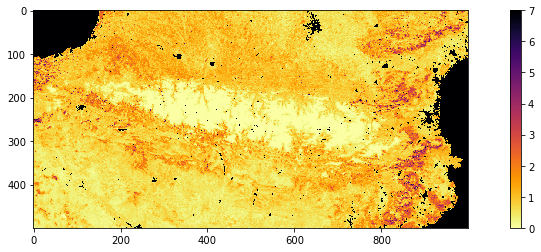

In [17]:
ofile = 'work/stitch_Lai_500m_2019_041_Tiles_h17v03_h18v03_h17v04_h18v04.vrt'
stitch_vrt = gdal.Open(ofile)

# get the lai data as sub-set directly
r0,r1 = 3900,4400
c0,c1 = 2000,3000

pyrenees = stitch_vrt.ReadAsArray(c0,r0,c1-c0,r1-r0)*0.1

fig, axs = plt.subplots(1,1,figsize=(15,4))
im = axs.imshow(pyrenees,vmax=7,\
                cmap=plt.cm.inferno_r,interpolation='nearest')
fig.colorbar(im, ax=axs)

print(f'shape now {pyrenees.shape}')

#### Exercise 3

* For doy 41 2019, extract and plot LAI of the sub-region around London by defining the approximate pixel coordinates of the area

## Filtering by vector dataset with `gdal.Warp`

We can apply spatial filtering from a vector dataset, e.g. in a shape file, using [`gdal.Warp`](https://gdal.org/programs/gdalwarp.html). We will explore this by filtering MODIS LAI by country boundary data.

A number of vectors with countries and administrative subdivisions are available. The [TM_WORLD_BORDERS shapefile](http://thematicmapping.org/downloads/TM_WORLD_BORDERS-0.3.zip) is popular and in the public domain. You can see it, and have a look at the data [here](https://koordinates.com/layer/7354-tm-world-borders-03/). The security on the website means that we cannot directly download the file, so instead we use the version stored in the `data` directory [`data/TM_WORLD_BORDERS-0.3.zip`].

We can use the command line [`gdal`](https://gdal.org/index.html) tool [`ogrinfo`

In [19]:
!ogrinfo data/TM_WORLD_BORDERS-0.3.shp -al -where FIPS="'LU'"

zsh:1: command not found: ogrinfo



We will use the [FIPS code](https://en.wikipedia.org/wiki/FIPS_county_code) to refer to countries within the dataset and the `gdal` function `gdal.Warp` to filter by this vector dataset. The syntax is:

    g = gdal.Warp("", "stitch_up.vrt",
             format = 'MEM',
             dstNodata=255,
             cropToCutline = True,
             cutlineDSName = 'data/TM_WORLD_BORDERS-0.3.shp', 
             cutlineWhere = "FIPS='UK'")


where:
* the first argument (`""` here) is the output filename
* the second argument (`"stitch_up.vrt"` here) is the input file
* `format = 'MEM'` means that the file is written to memory, rather than being stored in a file. 
* `dstNodata=255` means that any no data values will be set to 0. 
* `cropToCutline = True` forces the dataset to be cropped at the dataset boundary
* `cutlineDSName = 'data/TM_WORLD_BORDERS-0.3.shp'` specifies the vector boundary dataset
* `cutlineWhere = "FIPS='UK'"` provides the condition for sub-setting

We choose a value of 255 for `dstNodata` because we have seen that only values between 0 and 100 are valid for this dataset.

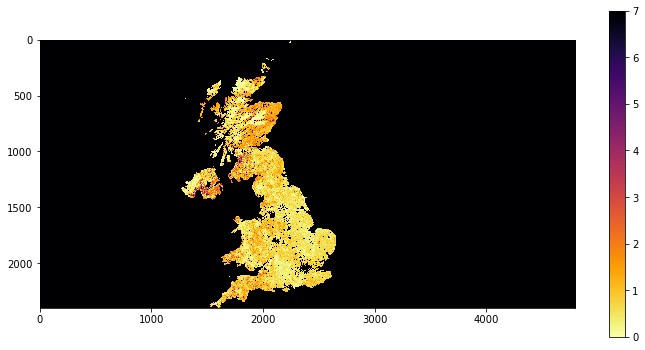

In [20]:
import gdal
import matplotlib.pyplot as plt
from geog0111.modisUtils import getModisFiles,stitchModisDate

kwargs = {
    'product'    : 'MCD15A3H',
    'tile'       : ['h17v03','h18v03'],
    'year'       : 2019,
    'doy'        : 41,
    'sds'        : 'Lai_500m'
}


warp_args = {
    'dstNodata'     : 255,
    'format'        : 'MEM',
    'cropToCutline' : False,
    'cutlineWhere'  : "FIPS='UK'",
    'cutlineDSName' : 'data/TM_WORLD_BORDERS-0.3.shp'
}

vrtFile = stitchModisDate(**kwargs)

# build a VRT 
stitch_vrt = gdal.BuildVRT(vrtFile, kwargs['sds'][0])
del stitch_vrt

# now warp it
g = gdal.Warp("", vrtFile,**warp_args)

fig, axs = plt.subplots(1,1,figsize=(12,6))
im = axs.imshow(g.ReadAsArray()*0.1,vmax=7,\
                cmap=plt.cm.inferno_r,interpolation='nearest')
fig.colorbar(im, ax=axs)



If you want to save the resultant file, e.g. to geoTiff or VRT file, then you would use e.g.:

    warp_args['format']   = 'GTiff'
    warp_args['options']  = ['COMPRESS=LZW']
    # compressed
    g = gdal.Warp("uk.tif", "stitch_up.tif",**warp_args)
    # force a write to disk
    g.FlushCache()
or

    warp_args['format'] = 'VRT'
    g = gdal.Warp("uk.vrt", "stitch_up.vrt",**warp_args)
    # force a write to disk
    g.FlushCache()

#### Exercise 4

* Plot the LAI for Luxemburg (`"FIPS='LU'"`) for doy 46, 2019
* find the mean LAI for Luxemburg for doy 46, 2019 to 2 d.p.

### `getModis`

For convenience, we can use the function `getModis` to combine these.

It returns a data file containing the tiled/warped data in a file (filename returned):

In [23]:
from geog0111.modisUtils import getModis

warp_args = {
    'dstNodata'     : 255,
    'format'        : 'MEM',
    'cropToCutline' : True,
    'cutlineWhere'  : "FIPS='UK'",
    'cutlineDSName' : 'data/TM_WORLD_BORDERS-0.3.shp'
}

kwargs = {
    'tile'      :    ['h17v03','h18v03','h17v04','h18v04'],
    'product'   :    'MCD15A3H',
    'sds'       :    'Lai_500m',
    'doys'       : [9,41],
    'year'      : 2019,
    'warp_args' : warp_args
}

datafiles,bnames = getModis(verbose=False,**kwargs)

print(datafiles,bnames)

['work/stitch_Lai_500m_2019_009_Tiles_h17v03_h18v03_h17v04_h18v04_warp.vrt', 'work/stitch_Lai_500m_2019_041_Tiles_h17v03_h18v03_h17v04_h18v04_warp.vrt'] ['2019-09', '2019-41']


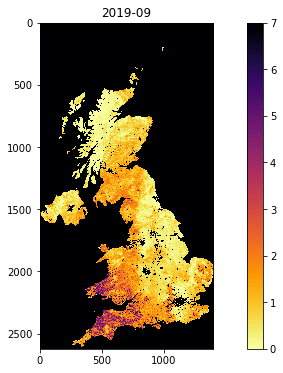

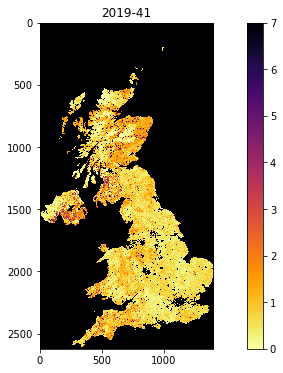

In [24]:
import gdal
import matplotlib.pyplot as plt

for datafile,bname in zip(datafiles,bnames):
    g = gdal.Open(datafile)
    fig, axs = plt.subplots(1,1,figsize=(12,6))
    im = axs.imshow(g.ReadAsArray()*0.1,vmax=7,\
                    cmap=plt.cm.inferno_r,interpolation='nearest')
    axs.set_title(bname)
    _=fig.colorbar(im, ax=axs)

#### Exercise 5

* Use `getModis` to plot the LAI for France for doy 9, 41 and 49, 2019
* find the median LAI for France for doy 9, 41 and 49, 2019 to 2 d.p.

## Summary

We have started to do some fuller geospatial processing now. We have seen how to use `gdal` for reading datasets, as well as mosaicing them and filtering by some vector dataset. We can take a subset of an image when we use `gdal.ReadAsArray()`. We have learned how to do these things using the MODIS HDF files and SDS descriptors.

We have also seen some utility functions to aid our use of these data. In particular, we can use `getModis` from [`geog0111.modisUtils`](geog0111/modisUtils.py) as a simple interface to download and stitch MODIS data. It makes use of a cache to avoid having to re-download the datasets each time we want to use them.


|function|comment|example and keywords|
|---|---|---|
|`g = gdal.Open(filename)` | Open geospatial file `filename` and return `gdal` object `g` (`None` if file not opened correctly)|
|`g.GetSubDatasets()` | Get list of sub-datasets from `gdal` object `g`| 
|`g.ReadAsArray(c0,r0,nc,nr)` | Read dataset from `gdal` object `g` into array. Form `c0` for `nc` columns and `r0` for `nr` rows. Set as `None` for defaults or don't give.|
|`gdal.BuildVRT(ofile, sds)` | create `gdal` VRT (wrapper) file called `ofile` for SDS/file `sds` | `files,sds = modis.get_files(year,doy)`|
||| `separate=True` for separate bands |
||| `ofile = f"work/stitch_full_{year}_{doy:03d}.vrt"`|
|||`stitch_vrt = gdal.BuildVRT(ofile, sds[0])`|
|`gdal.Info(f)` | Print information about geospatial file `f` ||
| `gdal.Warp(ofile,ifile)` | Warp `ifile` to `ofile` with keyword parameters | Keywords: 
|||`format = 'MEM'` or `format = 'GTiff'` : output format|
||| `options=['COMPRESS=LZW']` : compression option for GTiff etc.
||| `dstNodata=255`: no data value |
||| `cropToCutline = True` : whether to crop to cutline or bounds |
||| `cutlineDSName = 'data/TM_WORLD_BORDERS-0.3.shp'` : vector dataset for cutline|
||| `cutlineWhere = "FIPS='UK'"` : identifier information for cutline 
|`g.FlushCache()` | flush open `gdal` object `g` (force write to file) |



In [27]:
from geog0111.modisUtils import getModis

help(getModis)

Help on function getModis in module geog0111.modisUtils:

getModis(year=2019, doys=[1], sds='Lai_500m', tile=['h17v03', 'h18v03'], format='VRT', verbose=False, timeout=None, product='MCD15A3H', warp_args={})
    function to return Modis data array for defined
    conditions, for a single day and single SDS and
    product.
    
    Arguments:
        year     : int - year (2019)
        doys     : list of int - day of year ([1])
        sds      : SDS we want to retrieve ('Lai_500m')
        tile     : list of tiles to process (['h17v03','h18v03'])
        product  : MODIS data product (MCD15A3H')
        warp_args: cropping or warping arguments ({})
        
        ofile    : output (GTiff) filename
        format   : 'VRT' or 'GTiff' ('VRT' default)
        
        verbose  : verbose (False)
        timeout  : timeout (None) in seconds. Set to e.g. 1000 if
                   you are having problems
    
    
    generates stitched VRT files for each doy with the appropriate data,
 